# **作業四、 深度機器學習在影像辨識與生成的練習-Yale Face**

### 姓名：李博業
### 學號：410978058
<hr>

# 一、作業介紹

## (1)資料簡介
- <font size='4'>耶魯大學38人的面部照片。</font> <br>
 <br>
- <font size='4'>總共2410張，每張大小為192*168。</font> 

## (2)作業步驟及目的
- <font size='4'>使用Pytorch自行建置CNN模型並進行人臉辨識</font> <br>
 <br>
- <font size='4'>調整參數，以準確度最高為目的。</font> <br>
 <br>
- <font size='4'>最後，輸入隨意一張人臉圖片看其預測結果。</font> <br>
 <br>
- <font size='4'>目的是希望能訓練出好的影像識別深度學習模型，還有熟悉CNN的操作流程，此作業的成果及過程也可供未來的自己參考。</font> 

# 二、資料前處理

## (1)導入所需套件

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2
from torch import optim

## (2) 匯入及查看資料

In [3]:
def show_montage(X, n, m, h, w):
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: 
        X = np.c_[X, np.zeros((X.shape[0], w*h - X.shape[1]))] 
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
plt.show() 

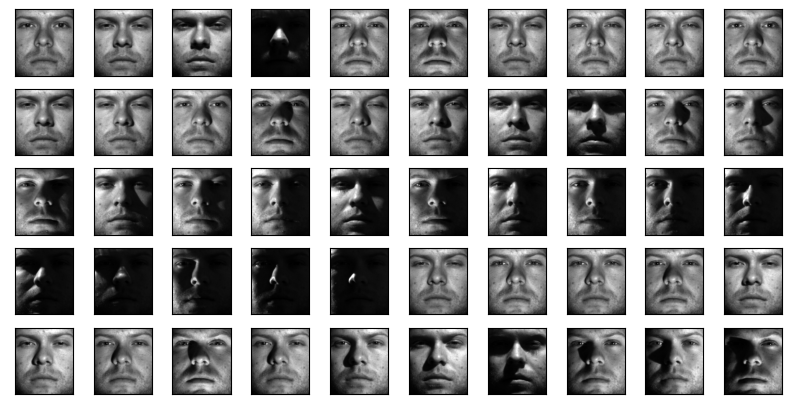

In [4]:
D = loadmat(r"C:\Users\UX425JA\Desktop\Shallow Machine Learning\allFaces.mat")
X = D['faces'] #32256*2410
X = X.T
k = np.ndarray.flatten(D['nfaces'])
n_persons = int(D['person'])
show_montage(X.T, 192, 168 ,5, 10)

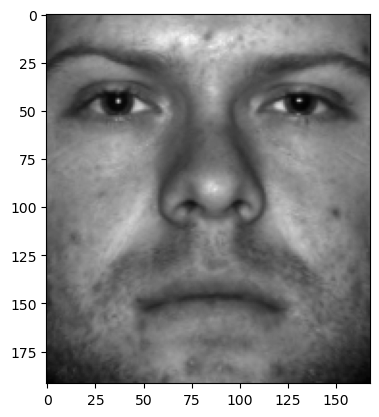

In [5]:
a = cv2.rotate(X[0,:].reshape(168,192), cv2.ROTATE_90_CLOCKWISE)
plt.imshow(a,cmap='gray')

## (3) 設定每張圖片的Label

In [5]:
y = np.zeros((2410),dtype=int)
for i,j in enumerate(k):
    y[sum(k[:i+1,]) : sum(k[:i+2,]),] = [i+1 for z in range(sum(k[:i+2,]) - sum(k[:i+1,]))]
y

array([ 0,  0,  0, ..., 37, 37, 37])

## (4) 切割訓練集、測試集
- <font size='4'>將七成的資料分為訓練集，三成分為測試集。</font> <br>
  <br>
- <font size='4'>將資料從numpy轉為tensor型態，才能送進深度學習模型中。</font><br>
  <br>
- <font size='4'>最後把訓練集及測試集各自合成DataLoader，設定Batch_size為128，且測試集的Batch不會變動順序(不洗牌)。</font>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=2)

In [12]:
X_train_std = torch.from_numpy(X_train).float() 
y_train = torch.from_numpy(y_train).long()
X_test_std = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [13]:
# convert to tensors numpy改成tensor
X_train_std = X_train_std.reshape(-1, 1, 168, 192) # convert to N x 1 x 192 x 168 for CNN #轉成原來圖的樣子 
X_test_std = X_test_std.reshape(-1, 1, 168, 192) # N x 1 x 192 x 168
 
# check shapes of data
print("訓練集圖片型態:{}".format( X_train_std.shape))
print("訓練集label型態:{}".format( y_train.shape))
print("測試集圖片型態:{}".format(X_test_std.shape))
print("測試集label型態:{}".format(y_test.shape))
 
# create dataloaders
train_dataset_std = TensorDataset(X_train_std, y_train) #訓練集 
test_dataset_std = TensorDataset(X_test_std, y_test) #測試集
batch_size = 128
train_loader_std = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=True)
test_loader_std = DataLoader(test_dataset_std, batch_size=batch_size, shuffle=False)

訓練集圖片型態:torch.Size([1687, 1, 168, 192])
訓練集label型態:torch.Size([1687])
測試集圖片型態:torch.Size([723, 1, 168, 192])
測試集label型態:torch.Size([723])


## 訓練集及測試集圖片型態解釋
- <font size='4'> 訓練集有1687張圖片，皆為一個通道，大小為168*192。</font> <br>
  <br>
- <font size='4'> 測試集有723張圖片，皆為一個通道，大小為168*192。</font> 

# 三、建置神經網路模型

In [14]:
#建置NN模型

class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Conv2d(1, 6, 5) #Layer1 
        self.conv2 = nn.Conv2d(6, 16, 5) #Layer2
        self.fc1 = nn.Linear(16*39*45, 120) #Layer3
        self.fc2 = nn.Linear(120, 60) #Layer4
        self.fc3 = nn.Linear(60, 38) 
    def forward(self, x):
         
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
 
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=38, bias=True)
)


## 建置模型解釋
- <font size='4'>卷積層的設定為第一層輸入1個通道，輸出6個通道；第二層輸入6個通道，輸出16個通道。有試圖改變輸出的通道為12、32等，但發現這樣的組合準確率最高。</font> <br>
  <br>
- <font size='4'>池化層的設定為2*2的window without zero-padding，起初認為沒有池化層的效果可能會較好，但嘗試後維持原樣比較好。</font> <br>
  <br>
- <font size='4'>全連結層的設定第一層有120個神經元、下一層是60個神經元，最後38個神經元。原本第二全連結層為84個神經元，嘗試過後發現這樣組合最好。</font> 

# 四、先觀察圖片輸入模型後的資料型態

In [10]:
first = train_dataset_std[0][0].reshape(1, 1, 168, 192)

out = net(first.to(device))
print("經過卷積神經網路後，最後的神經元數:{}".format(out.to("cpu").detach().numpy().shape[1]))

print("最後38個神經元中，輸出結果最大之索引:{}".format(out.data.max(1, keepdim=True)[1]))
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader_std) # 生成迭代
images, labels = next(dataiter) # 返回迭代器的下個項目
print("一個batch的型態:{}".format(images.shape))


經過卷積神經網路後，最後的神經元數:38
最後38個神經元中，輸出結果最大之索引:tensor([[30]])
[[ 7.8204978e-01  1.1214813e+00  9.1737010e-02  9.4622219e-01
  -1.4927138e-01 -1.5612103e+00 -3.7242699e-01 -4.0546489e-01
  -1.9839934e-01 -4.4280928e-01  1.9005638e-01  1.3956534e+00
  -1.0048501e+00 -2.2236985e-01  9.3704665e-01  7.4210739e-01
  -8.8379753e-01 -3.0792207e-03 -1.1328325e-02  7.7457237e-01
  -2.1864335e-01  2.9752573e-01 -3.1393318e+00 -1.2504456e+00
   6.2939966e-01 -3.8127285e-01  1.2137544e+00 -9.9165189e-01
   6.7074484e-01 -8.7450790e-01  2.1153316e+00 -5.9550714e-01
  -5.6573051e-01  6.9189705e-02 -5.0196654e-01 -8.4982193e-01
   6.9201368e-01 -8.1419587e-01]]
一個batch的型態:torch.Size([128, 1, 168, 192])


- <font size='4'>可知在38個神經元中，輸出結果最大的是在第31個神經元，值為2.11。</font> <br>
  <br>
- <font size='4'>一個batch的型態為 : 128張圖片，因為是灰度照所以一個通道，大小為168*192。</font> 

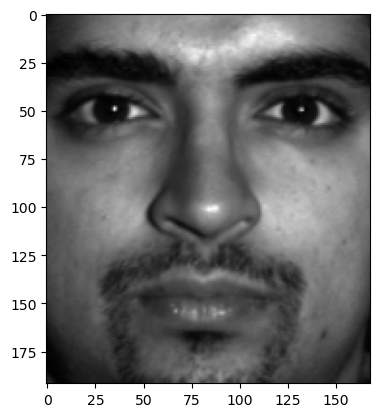

In [32]:
from torchvision.utils import make_grid
from torchvision.transforms import Normalize


a_image = images[0]
a_image_ = np.transpose(a_image, (2, 1, 0))
plt.imshow(a_image_, cmap='gray')
plt.axis()
plt.show()

# 五、設定損失函數

- <font size='4'>損失函數設定為交叉熵。</font> <br>
  <br>
- <font size='4'>優化器的學習率為0.001。</font> <br>
  <br>
- <font size='4'>本次訓練分兩批次都為此設定。</font> 

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 六、訓練模型

- <font size='4'>本次訓練分兩批次，第一次使用150 epochs，觀察其準確率後，匯出pth檔。</font> <br>
  <br>
- <font size='4'>第二次訓練匯入上一個pth檔後，再訓練200 epochs ，再觀察其準確率。</font> 

In [17]:
PATH = r'C:\Users\UX425JA\Desktop\Shallow Machine Learning\HW5\410978058_HW4_1.pt' 
torch.save(net.state_dict(), PATH)

In [15]:
#匯入已訓練150個epochs的模型
model = Net()
model.load_state_dict(torch.load(r'C:\Users\UX425JA\Desktop\Shallow Machine Learning\HW5\410978058_HW4_1.pt'))

<All keys matched successfully>

In [66]:
#再次訓練200次
epochs = 200
for epoch in range(epochs):  
    running_loss = 0.0
    for i, data in enumerate(train_loader_std, 0):            
            inputs, labels = data[0].to(device), data[1].to(device)           
            optimizer.zero_grad()            
            outputs = model(inputs) 
            loss = criterion(outputs, labels) # 計算loss           
            loss.backward() 
            optimizer.step()             
            running_loss += loss.item()
print('Finished Training')

Finished Training


## (1) 第一次訓練後訓練集及測試集結果(150epochs)

## 第一次訓練的訓練集結果

In [64]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader_std:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 100 %


## 第一次訓練的測試集結果

In [65]:
correct = 0
total = 0
with torch.no_grad(): #因為不是訓練，不須計算gradient
    for data in test_loader_std:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 95 %


- <font size='4'>第一次訓練150 epoch後，訓練集的準確率有100%，測試集的準確率有95%。</font> 

## (2) 進行第二輪訓練後的訓練集及測試集之結果(350epochs)

## 第二次訓練的訓練集結果

In [69]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader_std:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the train images(350 epochs): {100 * correct // total} %')

Accuracy of the network on the train images(350 epochs): 100 %


## 第二次訓練的測試集結果

In [70]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader_std:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the test images(350 epochs): {100 * correct // total} %')

Accuracy of the network on the test images(350 epochs): 95 %


- <font size='4'>再訓練200 epochs後，此模型總共訓練350 epochs，其測試集準確率為95%沒有變化，可知此模型已經訓練至極限。</font> 

# 六、隨機輸入圖片，看輸出結果

## (1) 設定函式

- <font size='4'>先把圖片全部轉成torch型態 </font> 

In [17]:
X_torch = torch.from_numpy(X).float() 
y_torch = torch.from_numpy(y).long()

- <font size='4'>設計一函式check_number，輸入1-38個人，輸出為那個人有幾張圖片可挑選。 </font> 

- <font size='4'>設計一函式predict，第一個輸入為1-38個人，第二個輸入為此人的第幾張圖片，輸出為模型預測結果和圖片。 </font> 

In [6]:
def check_number(y) :
    x = y - 1
    bold_start = '\033[1m'
    bold_end = '\033[0m'
    print(bold_start,"第{}個人的照片有{}張，從中挑一張吧!".format(y,k[x]),bold_end)

In [7]:
def predict(label, number) :
    d = k[label - 1]
    if 0 < number <= d : 
        x = label - 1
        a = sum(k[:x])
        b = a + number - 1
        image = X_torch[b]
        image = image.reshape(-1, 1, 168, 192)
        outputs = model(image.to(device))
        _, predicted = torch.max(outputs, 1)
        c = np.array(predicted)[0]+1
        bold_start = '\033[1m'
        bold_end = '\033[0m'
        print(bold_start,"你選的是第{}個人的第{}張圖，模型預測此圖為第{}個人".format(label,number,c),bold_end)
        image = image.squeeze(0) #降維
        a = X[sum(k[:(label-1)]):sum(k[:label]),:]
        e = cv2.rotate(X[b,:].reshape(168,192), cv2.ROTATE_90_CLOCKWISE)
        plt.imshow(e,cmap='gray')
        plt.title("The Picture you choose")
        print(bold_start,"下圖是你選擇的照片及第{}個人全部的照片".format(label),bold_end)
        show_montage(a.T, 192, 168 ,5,13)

## (2)-1 實際應用-編號16的人臉照

In [8]:
#想看第16個人
check_number(16)

 第16個人的照片有63張，從中挑一張吧! 


 你選的是第16個人的第63張圖，模型預測此圖為第16個人 
 下圖是你選擇的照片及第16個人全部的照片 


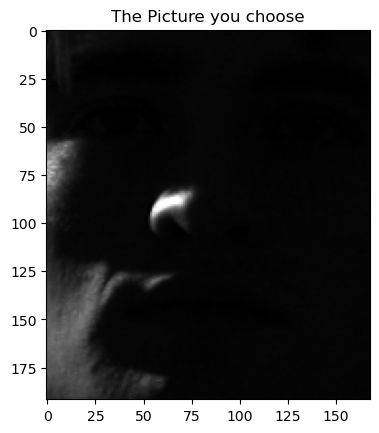

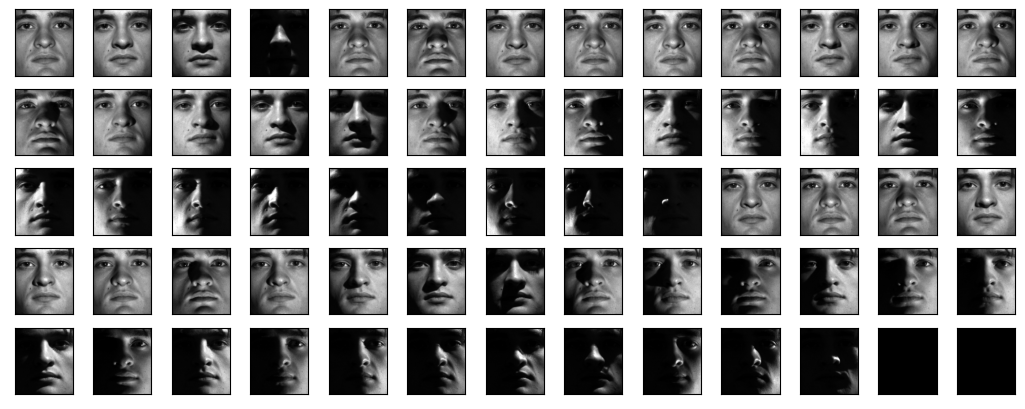

In [18]:
predict(16,63)

## (2)-2 實際應用-編號38的人臉照

In [19]:
#想看第38個人
check_number(38)

 第38個人的照片有64張，從中挑一張吧! 


 你選的是第38個人的第64張圖，模型預測此圖為第38個人 
 下圖是你選擇的照片及第38個人全部的照片 


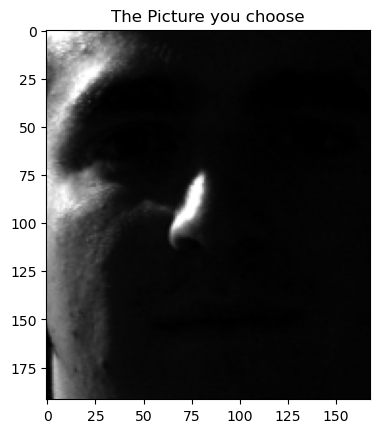

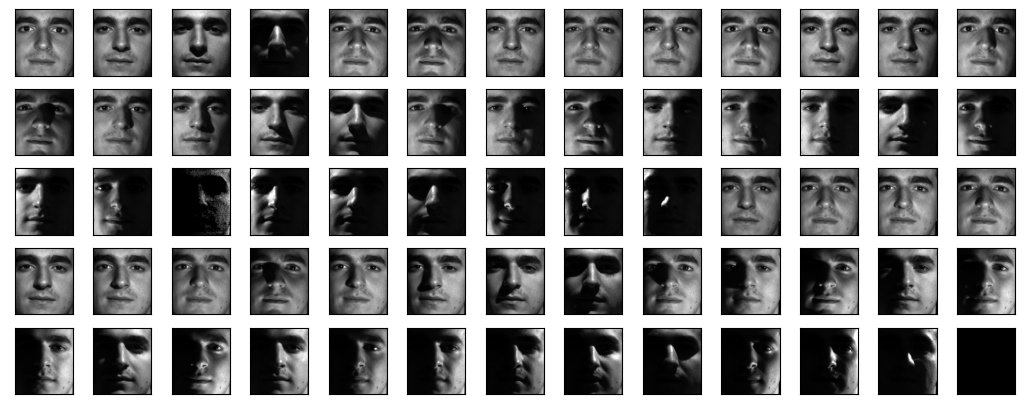

In [20]:
predict(38,64)

## (2)-3 實際應用-編號25的人臉照

In [131]:
#想看第25個人
check_number(25)

 第25個人的照片有64張，從中挑一張吧! 


 你選的是第25個人的第63張圖，模型預測此圖為第25個人 
 下圖是你選擇的照片及第25個人全部的照片 


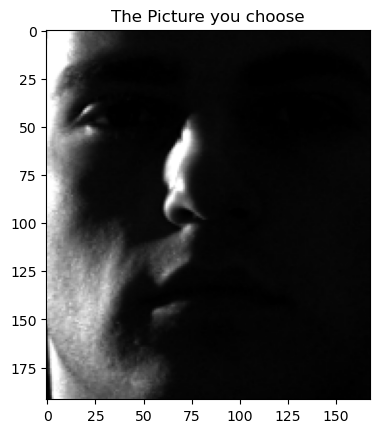

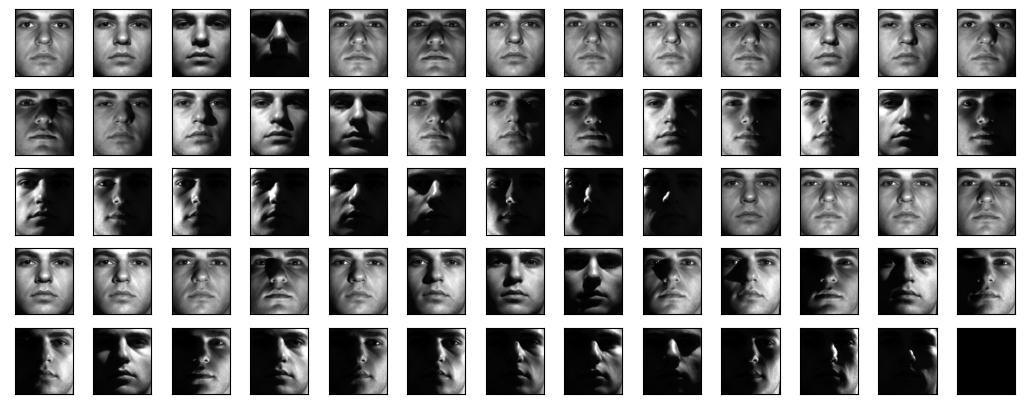

In [21]:
predict(25,63)

## (3) 丟入每一張測試集的準確率

In [46]:
correct = 0
total = 0
wrong_count = 0
fail =[]
fail_label = []
test_loader_1 = DataLoader(test_dataset_std, batch_size=1, shuffle=False)
for data in test_loader_1:
        wrong_count += 1
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if labels != predicted:
            fail.append(wrong_count)
            fail_label.append(labels.numpy())
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 95 %


## (4) 測試集被判斷錯誤的圖片

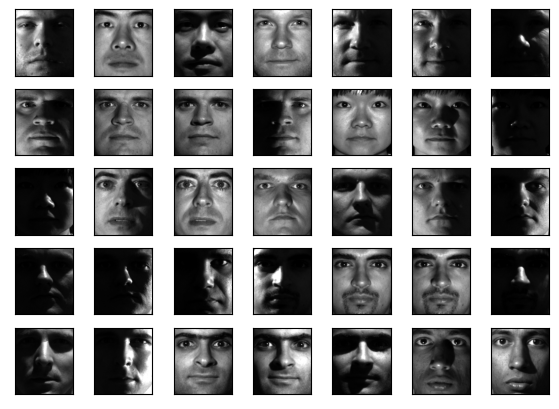

In [64]:
a = np.zeros((len(fail),32256))
for i in range(len(fail)) :
  a[i,:] = X[fail[i], : ] 
show_montage(a.T, 192, 168 ,5,7)

- <font size='4'>原本測試集是有設定batch_size的，但擔心不夠精準故觀察測試集每一張的結果，準確度仍為95%。 </font> <br>
  <br>
- <font size='4'>看到被判斷錯誤的圖片中，發現有些為光線不足，有些仍為五官清楚的圖片，表示模型仍有進步的空間。 </font> <br>

# 七、總結

- <font size='4'>做完此次作業後，我發現CNN模型建置非常重要，尤其是全連結層的神經元個數以及卷積層的神經元個數，我嘗試過一些不同的組合後，發現準確度有可能會差到5%以上；此外，學習率的調整就沒那麼的顯著。</font> <br>
  <br>
- <font size='4'>訓練150次epochs與350次epochs的準確度相同，這是在我意料之外的，因為我起初以為訓練較多次的模型準確率會上升一些，但這也不是壞事，在訓練更多次的情形下訓練集的準確度維持為100%，而測試集的準確度卻沒有下降，可知此模型比較沒有過擬合的疑慮。</font> <br>
  <br>
- <font size='4'>訓練更多次epochs的模型，測試集的準確度沒有上升也不太理想，且訓練集準確率已經達到100%，代表模型建置可以再更豐富一些，例如增加CNN的層數或是讓kernel_size更小，這樣或許可以讓測試集準確率再提升，並且盡量把光線足夠的圖片判斷正確，這是最後發現比較可惜的地方。</font> <br>
  <br>
- <font size='4'>模型預測效果不錯，在實際應用中我刻意選擇不太能看清楚人臉的圖像去預測，結果都預測正確，而且此題我還都使用CPU訓練。</font> 